In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_files = r"/content/drive/MyDrive/Data_M/dataset_fr/"

In [4]:
data_hate = pd.read_pickle(f"{path_files}data_hate.pkl")

In [5]:
data_hate.head(10)

,HITId,tweet,sentiment,text length,clean_tweet_min,clean_tweet_std,clean_tweet_lem
0,1,rt @user personnage ainsi q tte la clique gauc...,1,128,personnage ainsi q tte la clique gauchiste deg...,personnag tte cliqu gauchist deguis 1 macron!!...,personnage tout cliqu gauchiste deguise 1 macr...
1,2,@user @user @user bah oui t'as raison l'autre ...,1,62,bah oui t'as raison l'autre c'est un mongol.,raison mongol.,raison mongol.
2,3,moi j'ai personne à qui m'adresser pour réclam...,1,120,moi j'ai personne à qui m'adresser pour réclam...,m'adress réclam. voisin attard pu brui adminis...,me adresser réclamer. voisin attarder puant br...
3,4,@user @user c...est vrai que les anchois sont ...,0,102,c ... est vrai que les anchois sont aller sur ...,... vrai anchois aller lun invent million tech...,... vrai anchois aller lune invent million tec...
4,5,eh les renois faut se réveiller la @url,0,39,eh les renois faut se réveiller la,renois faut réveil,renois falloir réveiller
5,6,@user @user en algerie les migrants sont expul...,1,112,en algerie les migrants sont expulsés dans le ...,alger migr expuls désert crois bien qu'vision,algerie migrant expulser désert croi bien que ...
6,7,@user sjw et féministe twitter un sale combo,0,44,sjw et féministe twitter un sale combo,sjw fémin twitt sal combo,sjw féministe twitter sale combo
7,8,@user @user tu sais aussi pourquoi est au dess...,0,101,tu sais aussi pourquoi est au dessus? parce qu...,sais? veut ya d'ani ...,sai? vouloir ya de ani ...
8,9,@user @user mytho t'as juste voulu te faire ke...,1,105,mytho t'as juste voulu te faire ken par les re...,mytho voulu fair ken renois lyc voulu to,mytho vouloir faire ken renois lycer vouloir to
9,10,c’est un giga attardé mdrrr ils va vraiment se...,1,64,c’est un giga attardé mdrrr ils va vraiment se...,gig attard mdrrr va fair shoot,giga-octet attarder mdrrr aller faire shoote


### Données originales déséquilibrées 

Le classificateur utilisé par défaut pour classer différents ensembles de données est la régression logistique. 

Je vais utiliser ce dernier avec word_embedding et tfidfvectorizer afin d'en voir l'effet.

En termes de validation, K-Fold Cross Validation est utilisé.

In [6]:
# isoler les sentiments targets du fichier csv dans une variable nommée Y
target = data_hate['sentiment']

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

Encodage avec TFIDF Vectorizer+ regression logistique

In [130]:
tvec = TfidfVectorizer(stop_words=None)
lr = LogisticRegression(C=100, max_iter=1000)

In [131]:
model = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr)
])

Utilisation de la méthode de cross validation pour séparer le jeu d'entrainement du jeu de test .

Kfolds cross validation donne un modèle moins biaisé que le train_test split. La principale raison est qu'elle permet de s'assurer que toutes les observations du jeu de données original puissent apparaître dans l'ensemble d'entraînement, mais aussi dans l'ensemble utilisé pour le test. Dans la situation où les données d'input sont limitées, c'est l'une des meilleures solutions à considérer.

In [23]:
def lr_cv(X, Y, pipeline, average_method):

    cv_results = cross_validate(model, X, Y,cv=10)
    cv_results = pd.DataFrame(cv_results)
    return cv_results

In [25]:
col =['clean_tweet_min','clean_tweet_std','clean_tweet_lem']

In [132]:
"""Fonction qui affiche l'accuracy de chaque variante du dataset
paramètres: liste des noms des variables
sortie: affichage  des résultats
"""
def affiche_res(liste):
  for el in liste:
    res= lr_cv(data_hate[el],target, model, 'macro')
    print("Accuracy du modèle issu du dataset "f"{el} :"
        f"{res['test_score'].mean():.3f} +/- {res['test_score'].std():.3f}"
      )

In [133]:
affiche_res(col)

Accuracy du modèle issu du dataset clean_tweet_min :0.740 +/- 0.020
Accuracy du modèle issu du dataset clean_tweet_std :0.714 +/- 0.018
Accuracy du modèle issu du dataset clean_tweet_lem :0.725 +/- 0.025


On remarque que l'accuracy générale du modèle est autour de 70%. Mais sachant que le modèle est désiquilibré est ce pertinent de parler de cette accuracy. On va regarder de plus près la matrice de confusion.

In [68]:
def mat_conf(liste, target,model , pd):
  conf_mat=[]
  for i,el in enumerate(liste):
    conf_mat.append(confusion_matrix(cross_val_predict(model, data_hate[el], target, cv=10),target))
  return conf_mat

In [69]:
liste_mat=mat_conf(col, target,model, data_hate)

In [97]:
def draw_mat(conf_mat,string):
  print(string)
  matrice_proportions = np.zeros((2,2))
  for i in range(0,2):
      matrice_proportions[i,:] = conf_mat[i,:]/float(conf_mat[i,:].sum())
  names=['Neutre','Haineux']
  confusion_df = pd.DataFrame(matrice_proportions, index=names,columns=names)
  plt.figure(figsize=(5,5))
  sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
  plt.ylabel(r'Valeur réelle',fontsize=14)
  plt.xlabel(r'Valeur prédite',fontsize=14)
  plt.tick_params(labelsize=12)
  

In [98]:
def draw_liste_mat(liste, col):
  for n in range(len(liste)):
    draw_mat(liste[n],col[n])

clean_tweet_min
clean_tweet_std
clean_tweet_lem


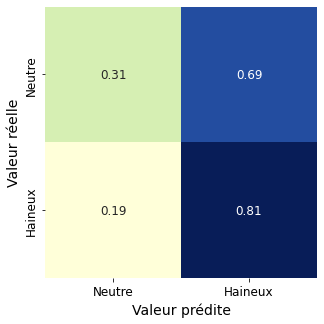

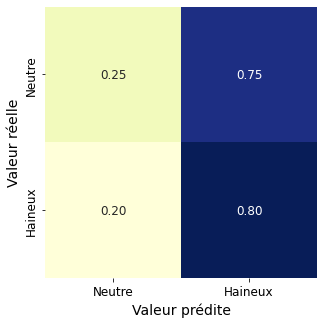

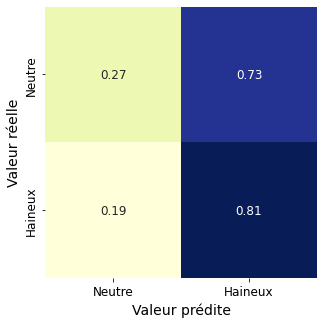

In [99]:
draw_liste_mat(liste_mat,col)

Comparaison avec un classificateur random

In [100]:
from sklearn.model_selection import train_test_split

# Write your code here.
train_data, test_data, train_data, test_target=train_test_split(data_hate["clean_tweet_lem"], target)

In [101]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(test_data, test_target)

DummyClassifier(random_state=0, strategy='most_frequent')

In [102]:
result= cross_validate(clf,data_hate["clean_tweet_lem"],target, cv=10)
scores = result["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation accuracy is: 0.795 +/- 0.001


Avec les données telles quelles sans aucun rééchantillonnage, et après comparaison avec un dummy classifier , on voit bien le poid du désiquilibre des données sur les résultats , on atteint les mêmes résultats entre une classification random et une classification avec regression logistique , il faut clairement revoir notre modèle et manipuler nos données .

Ici on utilise l'option de scoring "balanced accuracy" afin de connaitre la vraie accuracy du modèle , en enlevant le poid du désiquilibre des classes . 

In [136]:
"""Fonction qui affiche l'accuracy de chaque variante du dataset
paramètres: liste des noms des variables
sortie: affichage  des résultats
"""
def affiche_balanced(liste,model):
  for el in liste:
    res= cross_validate(model,data_hate[el],target, cv=10,scoring="balanced_accuracy" )
    print("Accuracy du modèle issu du dataset "f"{el} :"
        f"{res['test_score'].mean():.3f} +/- {res['test_score'].std():.3f}"
      )

In [137]:
affiche_balanced(col,model)

Accuracy du modèle issu du dataset clean_tweet_min :0.549 +/- 0.025
Accuracy du modèle issu du dataset clean_tweet_std :0.524 +/- 0.018
Accuracy du modèle issu du dataset clean_tweet_lem :0.531 +/- 0.029


In [109]:
result_dummy= cross_validate(clf,data_hate["clean_tweet_lem"],target, cv=10,scoring="balanced_accuracy" )
scores = result_dummy["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation accuracy is: 0.500 +/- 0.000


On remarque qu'il n'y a pas une grande différence entre le classifieur de notre regression logistique et notre random classifier.


Mettre le paramètre C à 100 au lieu de sa valeur par défaut 1 baisse l'accuracy général mais augmente l'accuracy balancée 

Test avec KNN 

In [125]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
model_knn = model = Pipeline([
    ('vectorizer', tvec),
    ('classifier', KNeighborsClassifier())
])

In [138]:
affiche_balanced(col,model_knn)

Accuracy du modèle issu du dataset clean_tweet_min :0.547 +/- 0.030
Accuracy du modèle issu du dataset clean_tweet_std :0.544 +/- 0.027
Accuracy du modèle issu du dataset clean_tweet_lem :0.542 +/- 0.023


Les résultats sont un peu meilleurs mais restent très insuffisant au regard de notre objectif

Le résultat du dataset Min est meilleure que les deux autres 

Underfitting

In [139]:
results= cross_validate(model_knn,data_hate["clean_tweet_min"],target, cv=10,scoring="balanced_accuracy",return_train_score=True )

In [140]:
results = pd.DataFrame(results)
results[["train_score", "test_score"]].mean()

train_score    0.720689
test_score     0.547434
dtype: float64

On remarque que le modèle performe sur les données d'entrainement mais pas sur ceux de test , il est en situation de sous apprentissage qu'on essaie de rattrapper en jouant avec les paramètres de notre classifieur

Grid search KNN

Nested cross validation

In [159]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'classifier__n_neighbors': (5,10, 20, 50, 100,200)}
model_grid_search = GridSearchCV(model_knn, param_grid=param_grid,
                                 n_jobs=2, cv=10,scoring="balanced_accuracy")

In [160]:
model_grid_search.fit(data_hate["clean_tweet_min"], target)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=2,
             param_grid={'classifier__n_neighbors': (5, 10, 20, 50, 100, 200)},
             scoring='balanced_accuracy')

In [161]:
cv_results_grid = cross_validate(
    model_grid_search, data_hate["clean_tweet_min"], target, cv=5, n_jobs=2,scoring="balanced_accuracy", return_estimator=True
)

In [162]:
for cv_fold, estimator_in_fold in enumerate(cv_results_grid["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'classifier__n_neighbors': 10}
Best hyperparameters for fold #2:
{'classifier__n_neighbors': 5}
Best hyperparameters for fold #3:
{'classifier__n_neighbors': 10}
Best hyperparameters for fold #4:
{'classifier__n_neighbors': 5}
Best hyperparameters for fold #5:
{'classifier__n_neighbors': 5}


In [163]:
model_grid_search.best_params_

{'classifier__n_neighbors': 5}

In [164]:
scores_grid = cv_results_grid["test_score"]

In [165]:
scores_grid

array([0.510196  , 0.54448643, 0.54759247, 0.51175549, 0.5760666 ])

meileur paramètre avec Min est 100

KNN AVEC CROSS VALIDATION best params

In [166]:
model_knn_best = model = Pipeline([
    ('vectorizer', tvec),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

In [167]:
cv_results = cross_validate(
    model_knn_best, data_hate["clean_tweet_min"], target, cv=5, scoring="balanced_accuracy",
    return_train_score=True,
)

In [168]:
cv_results = pd.DataFrame(cv_results)
cv_test_scores = cv_results['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} +/- {cv_test_scores.std():.3f}"
)

Generalization score with hyperparameters tuning:
0.542 +/- 0.023


Validation du meilleur modèle

In [170]:
from sklearn.model_selection import validation_curve

param_range=[5, 10, 20, 50, 100,200]
train_scores, test_scores = validation_curve(
    model_knn, data_hate["clean_tweet_min"], target, param_name="classifier__n_neighbors", param_range=param_range,
    cv=5, scoring="balanced_accuracy", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

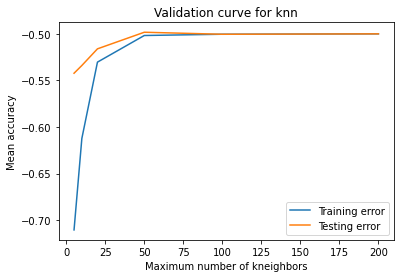

In [171]:
plt.plot(param_range, train_errors.mean(axis=1), label="Training error")
plt.plot(param_range, test_errors.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Maximum number of kneighbors")
plt.ylabel("Mean accuracy")
_ = plt.title("Validation curve for knn")

Méthodes de detection d'anomalies

In [172]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams

In [173]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, 
                                       contamination=0.2, random_state=5, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=0.2),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [174]:
X = tvec.fit_transform(data_hate['clean_tweet_lem'])

In [175]:
#utiliser la méthode de Tfidfvectorizer avec:
""" le cleaning étant déjà fait on uilise directement les données"""
print('Tweet before vectorization: {}'.format(data_hate['clean_tweet_min'][1]))


Tweet before vectorization: bah oui t'as raison l'autre c'est un mongol.


In [176]:
print('Tweet after vectorization: \n{}'.format(X[1]))

Tweet after vectorization: 
  (0, 4468)	0.4047772932636133
  (0, 5731)	0.914415301084897


In [179]:
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 1
    y_pred[y_pred == -1] = 0
    n_errors = (y_pred != target).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score : ",accuracy_score(target,y_pred))
    print("Classification Report :")
    print(classification_report(target,y_pred))

Isolation Forest: 1284
Accuracy Score :  0.680119581464873
Classification Report :
              precision    recall  f1-score   support

           0       0.21      0.21      0.21       821
           1       0.80      0.80      0.80      3193

    accuracy                           0.68      4014
   macro avg       0.50      0.50      0.50      4014
weighted avg       0.68      0.68      0.68      4014

Local Outlier Factor: 1494
Accuracy Score :  0.6278026905829597
Classification Report :
              precision    recall  f1-score   support

           0       0.08      0.08      0.08       821
           1       0.76      0.77      0.77      3193

    accuracy                           0.63      4014
   macro avg       0.42      0.42      0.42      4014
weighted avg       0.62      0.63      0.63      4014

Support Vector Machine: 1201
Accuracy Score :  0.7007972097658196
Classification Report :
              precision    recall  f1-score   support

           0       0.26      0